<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-phoenix-assets/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Summarization Classification Evals</h1>

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to evaluating summarization quality,
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

In [1]:
#####################
## N_EVAL_SAMPLE_SIZE
#####################
# Eval sample size determines the run time
# 100 samples: GPT-4 ~ 80 sec / GPT-3.5 ~ 40 sec
# 1,000 samples: GPT-4 ~15-17 min / GPT-3.5 ~ 6-7min (depending on retries)
# 10,000 samples GPT-4 ~170 min / GPT-3.5 ~ 70min
N_EVAL_SAMPLE_SIZE = 100

In [2]:
!pip install -qq "arize-phoenix-evals>=0.0.5" "openai>=1" ipython matplotlib pycm scikit-learn tiktoken nest_asyncio

ℹ️ To enable async request submission in notebook environments like Jupyter or Google Colab, optionally use `nest_asyncio`. `nest_asyncio` globally patches `asyncio` to enable event loops to be re-entrant. This is not required for non-notebook environments.

Without `nest_asyncio`, eval submission can be much slower, depending on your organization's rate limits. Speed increases of about 5x are typical.

In [3]:
import nest_asyncio

nest_asyncio.apply()

In [4]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd
import phoenix.evals.templates.default_templates as templates
from phoenix.evals import (
    OpenAIModel,
    download_benchmark_dataset,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of an LLM model and settings in addition to an evaluation prompt template against benchmark datasets of queries and retrieved documents with ground-truth relevance labels. We will be using the CNN Daily News Mail dataset. This dataset is commonly used for text summarization models as a benchmark.

In [5]:
df = download_benchmark_dataset(
    task="summarization-classification", dataset_name="summarization-test"
)
df.head()

document  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    It's the ultimate in slow-motion footage. The BBC is to air a two-hour, real-time documentary following a canalboat as it pootles its way along a British waterway at a leisurely 4mph. For many, the languid film will be as interesting as watching paint dry, but the Corporation hopes many viewers will find it a refreshing change from the usual frenetic pace of modern TV. There is no presenter, narrator, dialogue or music, so all viewers will hear are the sounds of the boat's engine, the lapping of the water and the local birdsong as the barge makes its way along a picturesque stretch of the Kennet and Avon Canal. 00.00: And they're off! 0-4mph in ten minutes . 34.07: Bridge over (not at all) troubled water . 41.50: Crazy boy racers scream past at 5mph . Aside

## Display Binary Summarization Classification Template

View the default template used to classify summarizations. You can tweak this template and evaluate its performance relative to the default.

In [6]:
print(templates.SUMMARIZATION_PROMPT_TEMPLATE)


You are comparing the summary text and it's original document and trying to determine
if the summary is good. Here is the data:
    [BEGIN DATA]
    ************
    [Summary]: {output}
    ************
    [Original Document]: {input}
    [END DATA]
Compare the Summary above to the Original Document and determine if the Summary is
comprehensive, concise, coherent, and independent relative to the Original Document.
Your response must be a single word, either "good" or "bad", and should not contain any text
or characters aside from that. "bad" means that the Summary is not comprehensive,
concise, coherent, and independent relative to the Original Document. "good" means the
Summary is comprehensive, concise, coherent, and independent relative to the Original Document.



Eval template variables:

- **input** : The document text to summarize
- **output** : The summary of the document

## Configure the LLM

Configure your OpenAI API key.

In [7]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

## Benchmark Dataset Sample
Sample size determines run time
Recommend iterating small: 100 samples
Then increasing to large test set

In [8]:
df_sample = (
    df.sample(n=N_EVAL_SAMPLE_SIZE)
    .reset_index(drop=True)
    .rename(columns={"document": "input", "summary": "output"})
)


## LLM Evals: Summarization Evals Classifications GPT-4
Run summarization classifications against a subset of the data.

Instantiate the LLM and set parameters.

In [9]:
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)

In [10]:
model("Hello world, this is a test if you are working?")

"Hello! I'm working perfectly. How can I assist you today?"

In [11]:
# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned
rails = list(templates.SUMMARIZATION_PROMPT_RAILS_MAP.values())
summarization_classifications = llm_classify(
    dataframe=df_sample,
    template=templates.SUMMARIZATION_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=20,
)["label"].tolist()

llm_classify |          | 0/100 (0.0%) | ⏳ 00:00<? | ?it/s


Evaluate the predictions against human-labeled ground-truth summarization labels.

              precision    recall  f1-score   support

        good       0.78      0.88      0.83        52
         bad       0.85      0.73      0.79        48

    accuracy                           0.81       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.82      0.81      0.81       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

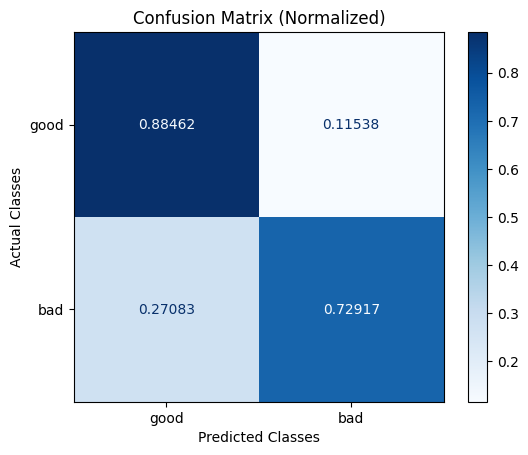

In [12]:
true_labels = df_sample["user_feedback"].map(templates.SUMMARIZATION_PROMPT_RAILS_MAP).tolist()
print(classification_report(true_labels, summarization_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels,
    predict_vector=summarization_classifications,
    classes=rails,
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)


## LLM Evals: Summarization Evals Classifications GPT-3.5
Run summarization classifications against a subset of the data.

In [13]:
model = OpenAIModel(model_name="gpt-3.5-turbo", temperature=0.0, request_timeout=20)

In [14]:
rails = list(templates.SUMMARIZATION_PROMPT_RAILS_MAP.values())
summarization_classifications = llm_classify(
    dataframe=df_sample,
    template=templates.SUMMARIZATION_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=20,
)["label"].tolist()

llm_classify |          | 0/100 (0.0%) | ⏳ 00:00<? | ?it/s

              precision    recall  f1-score   support

        good       0.69      0.81      0.74        52
         bad       0.74      0.60      0.67        48

    accuracy                           0.71       100
   macro avg       0.72      0.71      0.71       100
weighted avg       0.71      0.71      0.71       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

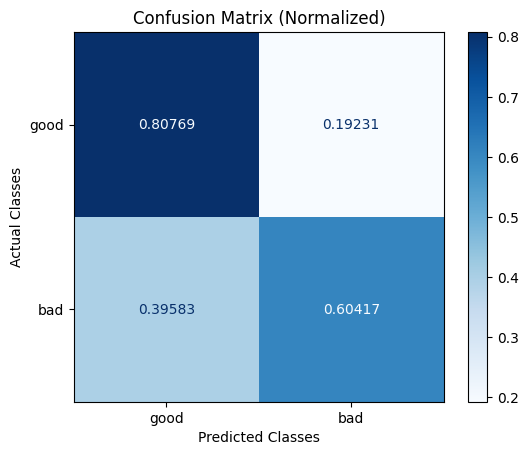

In [15]:
true_labels = df_sample["user_feedback"].map(templates.SUMMARIZATION_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, summarization_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels,
    predict_vector=summarization_classifications,
    classes=rails,
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)


## LLM Evals: Summarization Evals Classifications GPT-4 Turbo
Run summarization classifications against a subset of the data.

In [16]:
model = OpenAIModel(model_name="gpt-4-turbo-preview", temperature=0.0)

In [17]:
rails = list(templates.SUMMARIZATION_PROMPT_RAILS_MAP.values())
summarization_classifications = llm_classify(
    dataframe=df_sample,
    template=templates.SUMMARIZATION_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=20,
)["label"].tolist()

llm_classify |          | 0/100 (0.0%) | ⏳ 00:00<? | ?it/s

              precision    recall  f1-score   support

        good       0.95      0.67      0.79        52
         bad       0.73      0.96      0.83        48

    accuracy                           0.81       100
   macro avg       0.84      0.82      0.81       100
weighted avg       0.84      0.81      0.81       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

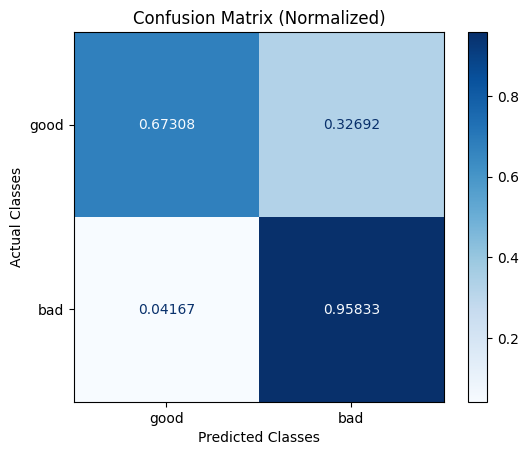

In [18]:
true_labels = df_sample["user_feedback"].map(templates.SUMMARIZATION_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, summarization_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels,
    predict_vector=summarization_classifications,
    classes=rails,
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)